# FF DFA Testing

In [29]:
# imports
from time import perf_counter
import json

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, average_precision_score, brier_score_loss
from sklearn.linear_model import LogisticRegression

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
import torch.optim as optim

from imblearn.over_sampling import BorderlineSMOTE, ADASYN, RandomOverSampler

import shap
from scipy.stats import spearmanr
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings("ignore")


seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

import os
os.makedirs("test_results/plots", exist_ok=True)

Using device: cpu


Test Configs

### Dataset
 
Wisconsin Dataset: Tabular Data

In [30]:
data = load_breast_cancer()
FEATURE_NAMES = data.feature_names
X = pd.DataFrame(data.data, columns=FEATURE_NAMES)
y = pd.Series(data.target)

df = X.copy()
df['target'] = y
df

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,0
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,0
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,0
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,0


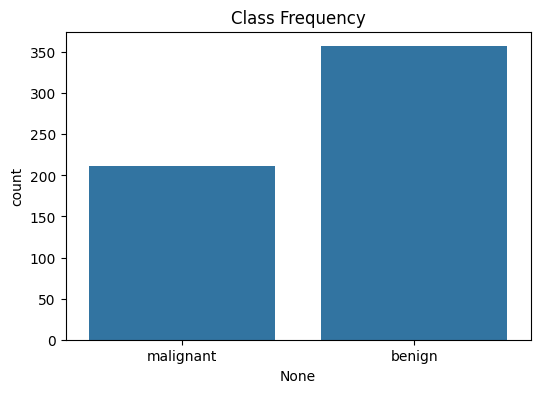

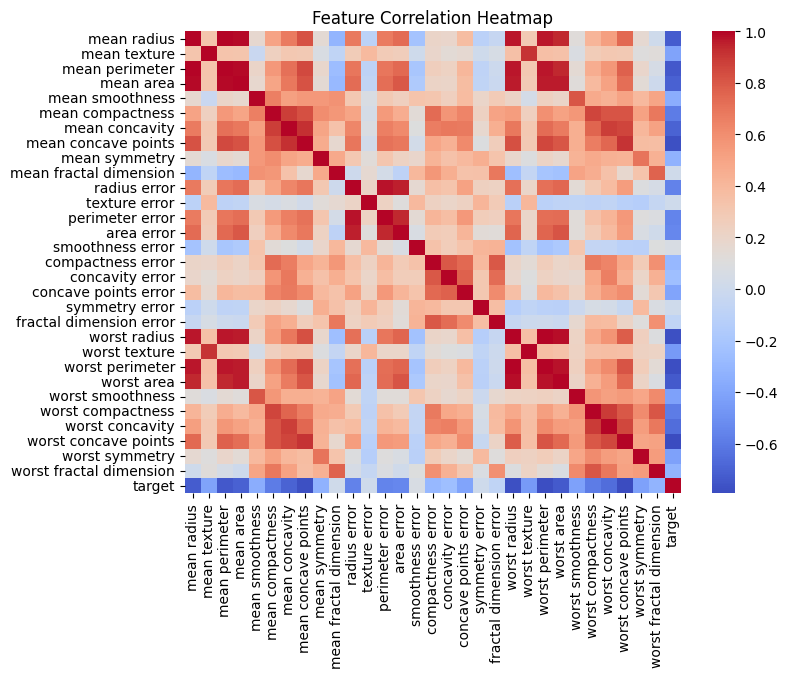

Top correlated features with target:
 worst concave points      -0.793566
worst perimeter           -0.782914
mean concave points       -0.776614
worst radius              -0.776454
mean perimeter            -0.742636
worst area                -0.733825
mean radius               -0.730029
mean area                 -0.708984
mean concavity            -0.696360
worst concavity           -0.659610
mean compactness          -0.596534
worst compactness         -0.590998
radius error              -0.567134
perimeter error           -0.556141
area error                -0.548236
worst texture             -0.456903
worst smoothness          -0.421465
worst symmetry            -0.416294
mean texture              -0.415185
concave points error      -0.408042
mean smoothness           -0.358560
mean symmetry             -0.330499
worst fractal dimension   -0.323872
compactness error         -0.292999
concavity error           -0.253730
fractal dimension error   -0.077972
symmetry error            

In [31]:
plt.figure(figsize=(6,4))
sns.countplot(x=y)
plt.title("Class Frequency")
plt.xticks([0, 1], data.target_names)
plt.show()

corr = df.corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, cmap='coolwarm', annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()

target_corr = corr['target'].drop('target').sort_values(ascending=True)
print("Top correlated features with target:\n", target_corr)

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# target_corr = X_train.corrwith(y_train)

# threshold = 0.2
# selected_features = target_corr[target_corr.abs() > threshold].index.tolist()
# deleted_features = target_corr[target_corr.abs() <= threshold].index.tolist()

# print(f"Selected features ({len(selected_features)}):\n{selected_features}\n")
# print(f"Deleted features ({len(deleted_features)}):\n{deleted_features}\n")

# X_train = X_train[selected_features]
# X_test = X_test[selected_features]

input_dim = X_train.shape[1]
output_dim = 2  # Binary classification
print(f"Input Features: {input_dim}, Output Classes: {output_dim}")

def prepare_data(imbalance_mode):
    scaler = StandardScaler()
    # scaling after oversampling lead to synthetic data leakage, but is that really a leakage?
    if imbalance_mode == "oversample":
        sm = BorderlineSMOTE(random_state=seed)  # RandomOversampler may cause overfitting, use ADASYN only if class imbalance too high; Borderline > SMOTE to preserve biologically coherent features
        print("Oversampling method: ", sm)
        scaler.fit(X_train)
        X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
        X_train_scaled = scaler.transform(X_train_res)
    else:
        X_train_scaled = scaler.fit_transform(X_train)
        y_train_res = y_train
    X_test_scaled = scaler.transform(X_test)

    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train_res, dtype=torch.long).to(device)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.long).to(device)

    class_counts = np.bincount(y_train_tensor.cpu().numpy())
    print(", ".join([f"Class {i}: {count}" for i, count in enumerate(class_counts)]))

    return X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, scaler

Input Features: 30, Output Classes: 2


Training Config

In [33]:
SEEDS = [4, 42, 4362]  # apparently, seeds not starting with '4' yield very poor initialisation and alginment in dfa
MODEL_WIDTHS = {
    'narrowing': [input_dim, 16, 8, output_dim], # slightly poorer performance on DFA, it would appeaer that DFA doesnt learn smaller latent repr well
    'base': [input_dim, 16, 16, output_dim],
    'widening': [input_dim, 64, 64, output_dim],
    'outglass': [input_dim, 64, 30, output_dim],
    'hourglass': [input_dim, 16, 30, output_dim],
}
IMBALANCE_MODES = ['none', 'class_weight', 'oversample']
LEARNING_RULES = ['bp', 'dfa'] 

EPOCHS = 128    # from learning notebook

# Seed utilities
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

## MLP Architecture 


In [34]:
class MLP(nn.Module):
    def __init__(self, dims, learning_rule='bp'):
        super().__init__()
        self.net_dims = dims
        self.learning_rule = learning_rule
        
        layers = []; self.linear_layers = []
        for i in range(len(dims)-1):
            linear = nn.Linear(dims[i], dims[i+1])
            self.linear_layers.append(linear); layers.append(linear)
            if i < len(dims)-2:
                layers.append(nn.ReLU())
        self.net = nn.Sequential(*layers)
        # self._init_weights() # same init for all models; UPDATE: Apparently gives a bit worse results ?

    def forward(self, x):
        return self.net(x)
    
    def _init_weights(self):
        for layer in self.linear_layers:
            nn.init.xavier_uniform_(layer.weight)
            nn.init.zeros_(layer.bias)

Training

BP

In [35]:
def train_bp(model, criterion, optimizer, X_tr_tensor, y_tr_tensor, X_te_tensor, y_te_tensor, epochs=128):
    train_losses, test_losses = [], []
    train_accs, test_accs = [], []

    grad_norms = []
    weight_updates = []
    convergence_rates = []

    prev_loss = None

    start_time = perf_counter()
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        
        # Training
        outputs = model(X_tr_tensor)
        loss = criterion(outputs, y_tr_tensor)
        loss.backward()
        
        # Gradients norm and ref
        total_norm = 0
        for p in model.parameters():
            if p.grad is not None:
                total_norm += p.grad.norm(2).item() ** 2
        grad_norm = total_norm ** 0.5
        grad_norms.append(grad_norm)
        
        # Update weights
        old_weights = [p.clone() for p in model.parameters()]
        optimizer.step()    
        update_norm = 0
        for old, new in zip(old_weights, model.parameters()):
            update_norm += (new - old).norm(2).item() ** 2
        weight_update_norm = update_norm ** 0.5
        weight_updates.append(weight_update_norm)
        
        # Convergence Rate
        if prev_loss is not None:
            improvement = abs(prev_loss - loss.item())
            rate = improvement / prev_loss if prev_loss > 0 else 0
        else: rate = None
        if rate is not None and epoch: convergence_rates.append(rate)
        prev_loss = loss.item()

        # Metrics
        preds_train = outputs.argmax(dim=1)
        train_acc = (preds_train == y_tr_tensor).float().mean().item()
        train_losses.append(loss.item())
        train_accs.append(train_acc)
        
        # Validation metrics
        model.eval()
        with torch.no_grad():
            test_out = model(X_te_tensor)
            test_loss = criterion(test_out, y_te_tensor).item()
            test_preds = test_out.argmax(dim=1)
            test_acc = (test_preds == y_te_tensor).float().mean().item()
        test_losses.append(test_loss)
        test_accs.append(test_acc)
        
    print(f"Epoch {epochs} | Train Loss: {loss.item():.4f}, Test Loss: {test_loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")

    end_time = perf_counter()
    elapsed = end_time - start_time
    print(f"Training completed in {elapsed:.2f} seconds")

    return {
        'training time': elapsed,
        'train_losses': train_losses,
        'test_losses': test_losses,
        'train_accs': train_accs,
        'test_accs': test_accs,
        'grad_norms': grad_norms,
        'weight_updates': weight_updates,
        'convergence_rates': convergence_rates,
    }

DFA

In [36]:
def train_dfa(model, criterion, optimizer, X_tr_tensor, y_tr_tensor, X_te_tensor, y_te_tensor, epochs=256):
    # --- DFA ---
    # Initialize fixed random feedback matrices B^l for each hidden layer
    # Here, model.net = [Linear1, ReLU, Linear2, ReLU, Linear3] with 3 linears
    B = []
    linear_layers = [m for m in model.net if isinstance(m, nn.Linear)]
    num_layers = len(linear_layers)
    for idx, layer in enumerate(linear_layers[:-1]):  # skip last (output) layer
        n_hidden = layer.out_features
        # normalize feedback matrix | To keep the scale of the feedback roughly same regardless of output size
        B_mat = torch.randn(n_hidden, output_dim, device=device) / (output_dim ** 0.5)  # for each hidden layer l, we sample a random matrix B^l ∈ R^{n_l x n_{l+1}} \in N(0,1/sqrt(n_{l+1}))
        B.append(B_mat)

    # --- same ---
    train_losses, test_losses = [], []
    train_accs, test_accs = [], []

    grad_norms = []
    weight_updates = []
    convergence_rates = []

    prev_loss = None

    start_time = perf_counter()
    # --- same ---

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        
        # --- Manual forward with activations & pre-activations for DFA --- ~ similar
        activations = [X_tr_tensor.to(device)]  # a^0 = x, a^l = \sigma(z^l)
        preacts = []                    # z^l = W^l a^{l-1} + b^l
        for layer in linear_layers:
            x = activations[-1]     # a^{l-1}
            z = layer(x)            #  z^l = W^l a^{l-1} + b^l
            preacts.append(z)
            # apply ReLU for hidden, identity for last
            a = torch.relu(z) if layer is not linear_layers[-1] else z
            activations.append(a)
        outputs = activations[-1]  # logits
        # --- Manual forward with activations & pre-activations for DFA --- ~ similar

        loss = criterion(outputs, y_tr_tensor.to(device))
        
        # --- DFA deltas ---
        batch_size = outputs.size(0)
        with torch.no_grad():
            probs = torch.softmax(outputs, dim=1)
            delta_L = probs - torch.nn.functional.one_hot(y_tr_tensor.to(device), num_classes=output_dim).float()  # Output layer delta: \delta^L = p - y
        deltas = [None] * num_layers
        deltas[-1] = delta_L
        # hidden layer update
        for l in range(num_layers-1):
            z = preacts[l]
            fb = delta_L @ B[l].T   # direct feedback projection of output loss = delta^L X B^l X; (B X O) X (O X n_l) = (B X n_l); B = batch_size
            delta = fb * (z>0).float()
            deltas[l] = delta   # layer loss delta = deltas^l = fb * ReLU(z^l)
        # --- DFA deltas ---

        # --- Gradient Norm & manual gradients ---
        total_norm = 0.0
        for l, layer in enumerate(linear_layers):
            W = layer.weight
            a_prev = activations[l]
            delta = deltas[l]
            grad_W = (delta.T @ a_prev) / batch_size   # \nabla W^l = \delta^l X a^{l-1} / B
            grad_b = delta.mean(dim=0)                 # \nabla b^l = mean(\delta^l)
            W.grad = grad_W
            layer.bias.grad = grad_b
            total_norm += grad_W.norm(2).item()**2 + grad_b.norm(2).item()**2
        grad_norm = total_norm**0.5
        grad_norms.append(grad_norm)
        # --- Gradient Norm ---


        # --- same ---

        # Update weights
        old_weights = [p.clone() for p in model.parameters()]
        optimizer.step()    
        update_norm = 0
        for old, new in zip(old_weights, model.parameters()):
            update_norm += (new - old).norm(2).item() ** 2
        weight_update_norm = update_norm ** 0.5
        weight_updates.append(weight_update_norm)
        
        # Convergence Rate
        cur_loss = loss.item()
        if prev_loss is not None and prev_loss > 0:
            improvement = abs(prev_loss - cur_loss)
            rate = improvement / prev_loss
        else:
            rate = 0.0
        if rate is not None and epoch: convergence_rates.append(rate)
        prev_loss = cur_loss
        
        # Metrics
        preds_train = outputs.argmax(dim=1)
        train_acc = (preds_train == y_tr_tensor.to(device)).float().mean().item()
        train_losses.append(cur_loss)
        train_accs.append(train_acc)
        

        # Validation metrics
        model.eval()
        with torch.no_grad():
            test_out = model(X_te_tensor.to(device))
            test_loss = criterion(test_out, y_te_tensor.to(device)).item()
            test_preds = test_out.argmax(dim=1)
            test_acc = (test_preds == y_te_tensor.to(device)).float().mean().item()
        test_losses.append(test_loss)
        test_accs.append(test_acc)
        

    print(f"Epoch {epochs} | Train Loss: {cur_loss:.4f}, Test Loss: {test_loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")
        
    end_time = perf_counter()
    elapsed = end_time - start_time
    print(f"Training completed in {elapsed:.4f} seconds")

    return {
        'training time': elapsed,
        'train_losses': train_losses,
        'test_losses': test_losses,
        'train_accs': train_accs,
        'test_accs': test_accs,
        'grad_norms': grad_norms,
        'weight_updates': weight_updates,
        'convergence_rates': convergence_rates,
    }

Evaluators

In [37]:
def shap_values(model_state_dict, model_dims, X_te):
   # ----- Load model -----
    model = MLP(model_dims).cpu()
    model.load_state_dict(model_state_dict)
    model.eval()

    X_te_shap = X_te.cpu()     # input, already tesnor no need to convert. If not tensor --> convert

    # SHAP explanations
    explainer = shap.DeepExplainer(model, X_te_shap)
    shap_vals = explainer.shap_values(X_te_shap)    # (num_samples, num_features, num_classes)
    # print(shap_vals.shape)

    # ----- Extract class 0 attributions -----
    attr = shap_vals[:, :, 0]   # (num_samples, num_features)
    return attr


def calibration_metrics(y_true, y_prob, n_bins=10):
    # Brier Score
    brier = brier_score_loss(y_true, y_prob)

    # Expected Calibration Error (ECE)
    bin_edges = np.linspace(0.0, 1.0, n_bins + 1)
    binids = np.digitize(y_prob, bin_edges[1:-1])
    ece = 0.0
    for i in range(n_bins):
        bin_mask = binids == i
        if np.sum(bin_mask) > 0:
            bin_conf = np.mean(y_prob[bin_mask])
            bin_acc = np.mean(y_true[bin_mask])
            ece += np.abs(bin_conf - bin_acc) * np.sum(bin_mask)
    ece /= len(y_true)

    # Calibration slope and intercept
    eps = 1e-7
    y_prob_safe = np.clip(y_prob, eps, 1-eps)
    logit_preds = np.log(y_prob_safe / (1-y_prob_safe))
    lr = LogisticRegression(solver="lbfgs")
    lr.fit(logit_preds.reshape(-1, 1), y_true)
    slope = lr.coef_[0][0]
    intercept = lr.intercept_[0]

    return brier, ece, slope, intercept

**Brier score** measures the mean squared difference between predicted probabilities and actual outcomes. Lower score --> better calibration. 

**ECE (Expected Calibration Error)** quantifies the difference between predicted confidence and actual accuracy. Lower values --> better alignment between confidence and correctness. 

**Calibration slope** near 1 and **intercept** near 0 --> well-calibrated models. Deviations imply miscalibrated confidence scaling. 

slope >> 1: overfitting; << 1: underfitting
intercept >> 1: probs too high, << 1: probs too low


Fold

In [38]:
def final_metrics(model, X_te_tensor, y_te_tensor):
    model.eval()
    with torch.no_grad():
        test_out = model(X_te_tensor)
        test_preds = test_out.argmax(dim=1)

    y_true = y_te_tensor.cpu().numpy()
    y_pred = test_preds.cpu().numpy()

    probs = torch.softmax(test_out, dim=1)[:, 0].cpu().numpy()
    report = classification_report(y_true, y_pred, output_dict=True)

    brier, ece, slope, intercept = calibration_metrics((y_true == 0).astype(int), probs)
    # shap_results = shap_values(model.state_dict(), model_dims=model.net_dims, X_te=X_te_tensor)  # (num_samples, num_features)
    
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "f1_macro": f1_score(y_true, y_pred, average="macro"),
        "f1_weighted": f1_score(y_true, y_pred, average="weighted"),
        "roc_auc": roc_auc_score((y_true==0).astype(int), probs),
        "aucpr": average_precision_score((y_true==0).astype(int), probs),
        "precision_0": report["0"]["precision"],
        "recall_0": report["0"]["recall"],
        "precision_1": report["1"]["precision"],
        "recall_1": report["1"]["recall"],
        "brier_score": brier,
        "ece": ece,
        "slope": slope,
        "intercept": intercept,
        # "SHAP_values": shap_results.tolist(),
        }


def run_experiment(model, criterion, optimizer, X_tr_tensor, y_tr_tensor, X_te_tensor, y_te_tensor, epochs=128):
    if model.learning_rule == 'bp':
        results = train_bp(model, criterion, optimizer, X_tr_tensor, y_tr_tensor, X_te_tensor, y_te_tensor, epochs)
    
    elif model.learning_rule == 'dfa':
        results = train_dfa(model, criterion, optimizer, X_tr_tensor, y_tr_tensor, X_te_tensor, y_te_tensor, epochs)
    
    final_metrics_results = final_metrics(model, X_te_tensor, y_te_tensor)

    return results, final_metrics_results

RUN TESTS

In [39]:
exp_results = {}
exp_count = 0
total_experiments = len(LEARNING_RULES)*len(IMBALANCE_MODES)*len(MODEL_WIDTHS)*len(SEEDS)

for learning_rule in LEARNING_RULES:
    exp_results[learning_rule] = {}

    for imbalance_mode in IMBALANCE_MODES:
        exp_results[learning_rule][imbalance_mode] = {}
        
        for model_name, widths in MODEL_WIDTHS.items():
            exp_results[learning_rule][imbalance_mode][model_name] = {}

            for seed in SEEDS:
                exp_count += 1
                set_seed(seed)
                print(f"\n--- [Exp # {exp_count}/{total_experiments}] Rule: {learning_rule}, Imbalance handling: {imbalance_mode}, Model: {model_name}: {widths}, Seed: {seed} ---")

                X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, scaler = prepare_data(imbalance_mode=imbalance_mode)

                model = MLP(widths, learning_rule=learning_rule).to(device)
                optimizer = optim.Adam(model.parameters(), lr=0.001)

                if imbalance_mode == "class_weight":
                    class_counts = np.bincount(y_train.values)
                    class_weights = 1.0 / class_counts
                    class_weights = class_weights / class_weights.sum()
                    print(", ".join([f"Class {i}: normalised weight = {w:.4f}" for i, w in enumerate(class_weights)]))
                    weight_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)
                    criterion = nn.CrossEntropyLoss(weight=weight_tensor)
                else:
                    criterion = nn.CrossEntropyLoss()

                results, final_metrics_results = run_experiment(model, criterion, optimizer, 
                                                                X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, 
                                                                epochs=EPOCHS)

                exp_results[learning_rule][imbalance_mode][model_name][seed] = {
                    "results": results,
                    "final_metrics": final_metrics_results
                }

# print(exp_results) 
with open("test_results/exp_results.json", "w") as f:
    json.dump(exp_results, f, indent=2) 
print("\nExperiment results saved to test_results/exp_results.json")                    


--- [Exp # 1/90] Rule: bp, Imbalance handling: none, Model: narrowing: [30, 16, 8, 2], Seed: 4 ---
Class 0: 170, Class 1: 285
Epoch 128 | Train Loss: 0.1478, Test Loss: 0.1765, Train Acc: 0.9758, Test Acc: 0.9561
Training completed in 0.18 seconds

--- [Exp # 2/90] Rule: bp, Imbalance handling: none, Model: narrowing: [30, 16, 8, 2], Seed: 42 ---
Class 0: 170, Class 1: 285
Epoch 128 | Train Loss: 0.1219, Test Loss: 0.1464, Train Acc: 0.9714, Test Acc: 0.9561
Training completed in 0.18 seconds

--- [Exp # 3/90] Rule: bp, Imbalance handling: none, Model: narrowing: [30, 16, 8, 2], Seed: 4362 ---
Class 0: 170, Class 1: 285
Epoch 128 | Train Loss: 0.1197, Test Loss: 0.1441, Train Acc: 0.9780, Test Acc: 0.9386
Training completed in 0.17 seconds

--- [Exp # 4/90] Rule: bp, Imbalance handling: none, Model: base: [30, 16, 16, 2], Seed: 4 ---
Class 0: 170, Class 1: 285
Epoch 128 | Train Loss: 0.0797, Test Loss: 0.1066, Train Acc: 0.9868, Test Acc: 0.9737
Training completed in 0.17 seconds

---

Aggregate Statistics

In [40]:
with open("test_results/exp_results.json", "r") as f:
    exp_results = json.load(f)

from collections import defaultdict
epoch_metrics = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))  # [rule][imbalance][metric] = list of lists per epoch
final_metrics = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))  # [rule][imbalance][metric] = list of values
max_epoch = EPOCHS
for rule in exp_results:
    for imbalance in exp_results[rule]:
        for model in exp_results[rule][imbalance]:
            for seed in exp_results[rule][imbalance][model]:
                res = exp_results[rule][imbalance][model][seed]
                epoch = res['results']
                final = res['final_metrics']

                for metric in ['train_losses', 'test_losses', 'train_accs', 'test_accs', 'grad_norms', 'weight_updates', 'convergence_rates']:
                    epoch_metrics[rule][imbalance][metric].append(epoch[metric][:max_epoch])

                # Final metrics
                final_metrics[rule][imbalance]['training_time'].append(res['results']['training time'])
                for key, val in final.items():
                    if key != "SHAP_values":
                        final_metrics[rule][imbalance][key].append(val)


# print final metrics summary
print(f"{'---- METRIC SUMMARY FOR EACH IMBALANCE METHOD ----':^80}")
for imbalance in IMBALANCE_MODES:
    print(f"\n\nIMBALANCE HANDLING: {imbalance}")
    print("-" * 80)
    for metric in final_metrics[rule][imbalance]:
        row = []
        for rule in LEARNING_RULES:
            values = final_metrics[rule][imbalance][metric]
            mean = np.mean(values)
            std = np.std(values)
            row.append(f"  {rule.upper():>}: {mean:.4f} ± {std:.4f}  ")
        print(f"{metric:<20} | " + " | ".join(row))

               ---- METRIC SUMMARY FOR EACH IMBALANCE METHOD ----               


IMBALANCE HANDLING: none
--------------------------------------------------------------------------------
training_time        |   BP: 0.1713 ± 0.0084   |   DFA: 0.1923 ± 0.0165  
accuracy             |   BP: 0.9596 ± 0.0105   |   DFA: 0.9444 ± 0.0168  
f1_macro             |   BP: 0.9570 ± 0.0113   |   DFA: 0.9403 ± 0.0183  
f1_weighted          |   BP: 0.9598 ± 0.0105   |   DFA: 0.9444 ± 0.0169  
roc_auc              |   BP: 0.9953 ± 0.0014   |   DFA: 0.9906 ± 0.0046  
aucpr                |   BP: 0.9931 ± 0.0022   |   DFA: 0.9863 ± 0.0062  
precision_0          |   BP: 0.9273 ± 0.0195   |   DFA: 0.9233 ± 0.0253  
recall_0             |   BP: 0.9667 ± 0.0190   |   DFA: 0.9270 ± 0.0403  
precision_1          |   BP: 0.9802 ± 0.0109   |   DFA: 0.9579 ± 0.0225  
recall_1             |   BP: 0.9556 ± 0.0126   |   DFA: 0.9546 ± 0.0164  
brier_score          |   BP: 0.0304 ± 0.0057   |   DFA: 0.0441 ± 0.0134

DFA achieves reasonably similar performance to BP across all imbalance handling strategies. 

The best overall performance for both methods is achieved with **no imbalance handling**, suggesting THIS dataset's class distribution does not require correction. Introducing **class weighting** slightly improves minority class recall but leads to small drops in accuracy and calibration.

**Oversampling** yields the poorest performance, especially for DFA, likely due to overfitting or data redundancy. BP is also better calibrated and slightly faster in training. DFA might already be robust due to weaker alignment of gradients.

A slope > 1 with a negative intercept indicates the model is a bit overconfident and underpredicts probabilities for positive outcomes; but well within range. However, this effect is more pronounced in DFA than BP which might again be attributed to the weaker gradient alignment.

Plots

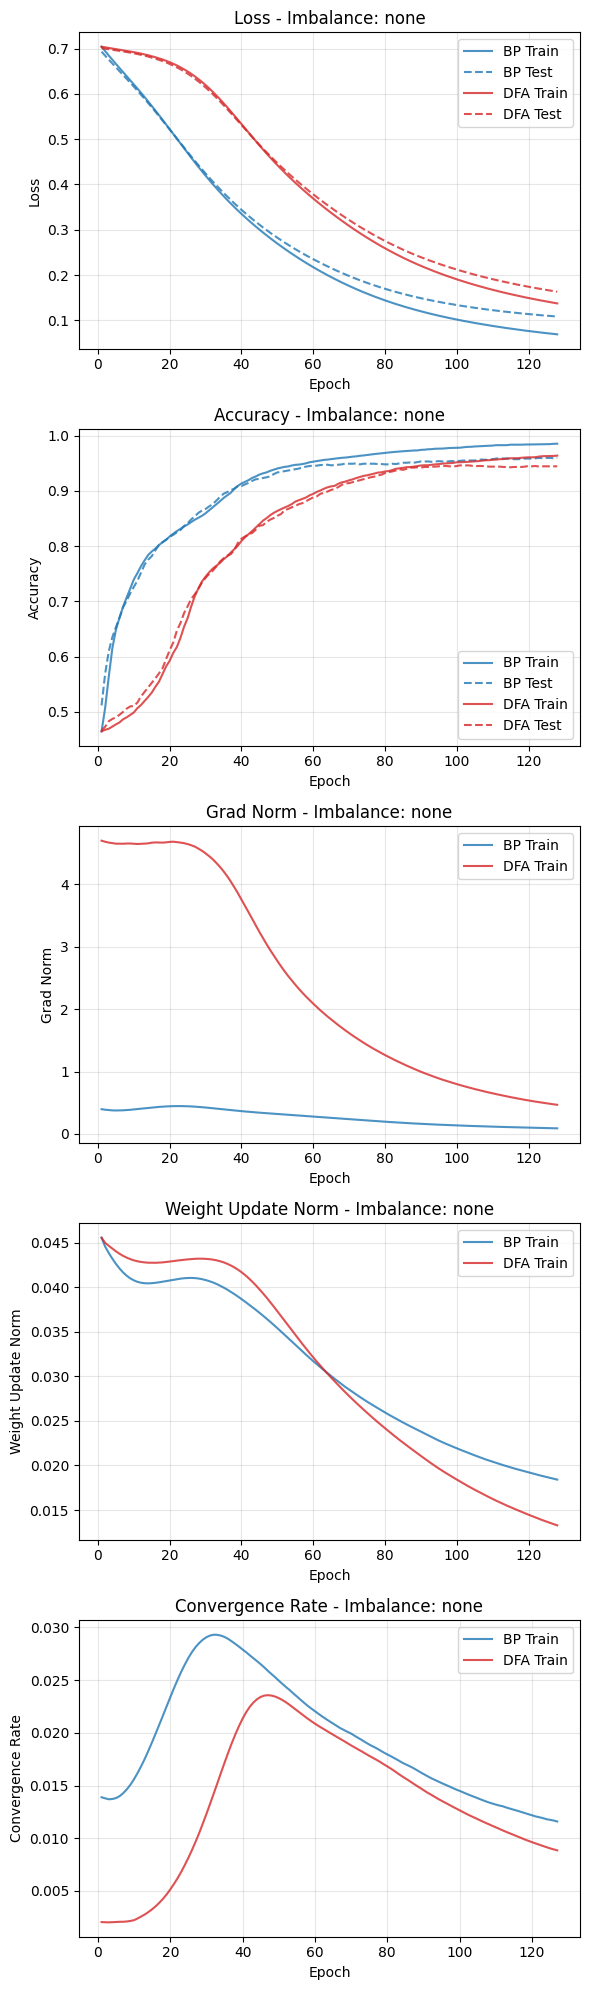

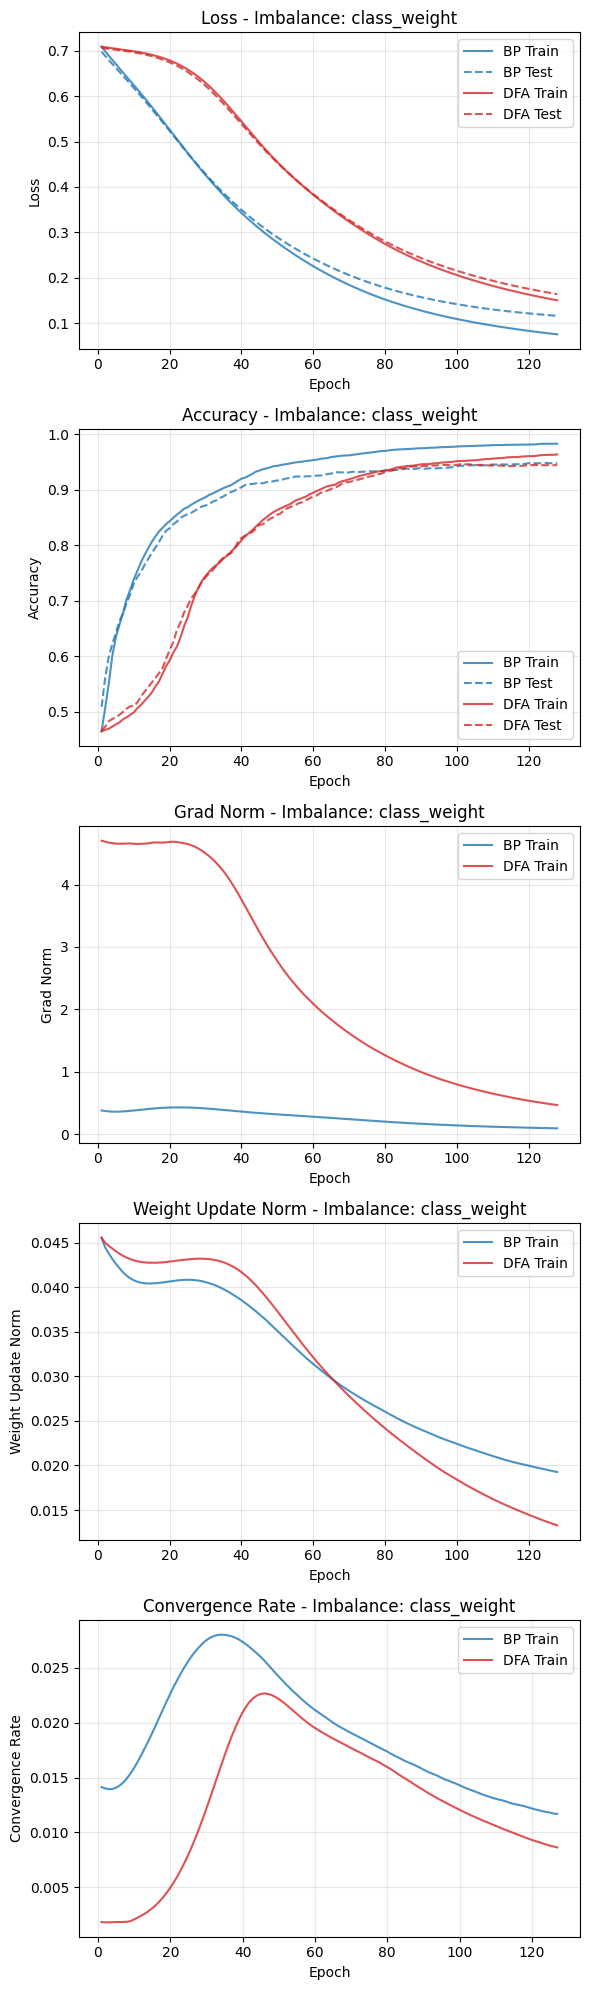

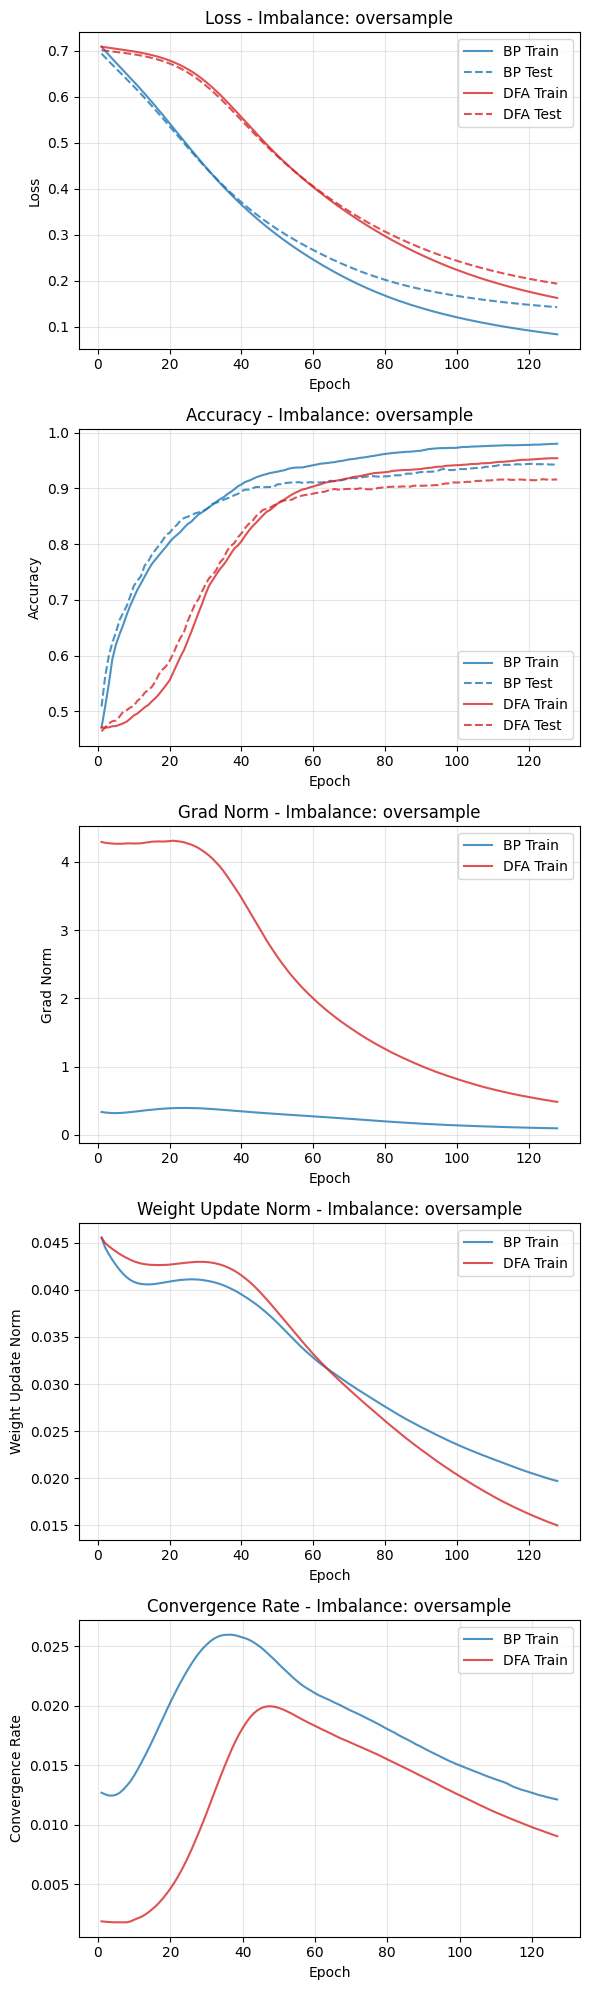

In [43]:
# model impacts
os.makedirs("test_results/plots/models", exist_ok=True)
for imbalance in IMBALANCE_MODES:
    for model_name, model_dims  in MODEL_WIDTHS.items():
        fig, ax = plt.subplots(figsize=(8, 5))
        for rule, color in zip(LEARNING_RULES, ["tab:blue", "tab:red"]):
            acc_train = []; acc_test = []
            for seed in SEEDS:
                metrics = exp_results[rule][imbalance][model_name][str(seed)]['results']
                acc_train.append(metrics['train_accs'])
                acc_test.append(metrics['test_accs'])

            mean_train = np.mean(np.array(acc_train), axis=0)
            mean_test = np.mean(np.array(acc_test), axis=0)
            epochs = np.arange(1, len(mean_train)+1)

            ax.plot(epochs, mean_train, label=f"{rule.upper()} Train", color=color, linestyle='-')
            ax.plot(epochs, mean_test, label=f"{rule.upper()} Test", color=color, linestyle='--')

        ax.set_title(f"Avg Accuracy | {model_name.upper()} Model : {model_dims} | Imb: {imbalance}")
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Accuracy")
        ax.legend()
        ax.grid(alpha=0.3)
        fig.tight_layout()
        fig.savefig(f"test_results/plots/models/{model_name}_{imbalance}.png")
        plt.close(fig)


# ---- Display and save aggregated plots per imbalance ----
metrics_to_plot = {
    "loss": ("train_losses", "test_losses"),
    "accuracy": ("train_accs", "test_accs"),
    "grad_norm": ("grad_norms", None),
    "weight_update_norm": ("weight_updates", None),
    "convergence_rate": ("convergence_rates", None),
}

for imbalance in IMBALANCE_MODES:
    fig, axes = plt.subplots(len(metrics_to_plot), 1, figsize=(6, 4*len(metrics_to_plot)))
    for i, (plot_name, (train_key, test_key)) in enumerate(metrics_to_plot.items()):
        ax = axes[i]
        for rule, color in zip(LEARNING_RULES, ["tab:blue", "tab:red"]):
            train_vals_all = []; test_vals_all = []
            for model in MODEL_WIDTHS:
                for seed in SEEDS:
                    result = exp_results[rule][imbalance][model][str(seed)]['results']
                    train_vals_all.append(result[train_key])
                    if test_key: test_vals_all.append(result[test_key])
            avg_train = np.mean(np.array(train_vals_all), axis=0)
            epochs = np.arange(1, len(avg_train)+1)
            ax.plot(epochs, avg_train, color=color, linestyle='-', alpha=0.8, label=f"{rule.upper()} Train")

            if test_key:
                avg_test = np.mean(np.array(test_vals_all), axis=0)
                ax.plot(epochs, avg_test, color=color, linestyle='--', alpha=0.8, label=f"{rule.upper()} Test")

        ax.set_title(f"{plot_name.replace('_', ' ').title()} - Imbalance: {imbalance}")
        ax.set_xlabel("Epoch")
        ax.set_ylabel(plot_name.replace("_", " ").title())
        ax.legend()
        ax.grid(alpha=0.3)
    fig.tight_layout()
    fig.savefig(f"test_results/plots/summary_{imbalance}.png", dpi=512)
    plt.show()